# Feature Generating and Engineering
This notebook is for generating the features put into the model.

In [1]:
# Packages Load
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import time
from tqdm import tqdm_notebook

In [2]:
# Read Files
events = pd.read_pickle('data/events.pkl')
attr = pd.read_pickle('data/attr_long.pkl')
session = pd.read_pickle('data/session.pkl')

In [3]:
submission = pd.read_csv('data/submission.csv')

In [4]:
events.head()

,session_id,event,event_timestamp,event_value,user_id_hash
0,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


Since our predictions are based on users, we need to create features on user base.

In [5]:
print(datetime.utcfromtimestamp(session.start_timestamp.min()/1000).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.utcfromtimestamp(session.start_timestamp.max()/1000).strftime('%Y-%m-%d %H:%M:%S'))

2018-10-01 07:00:04
2018-12-14 23:59:59


We will create labels during period Dec 1st and Dec 14th, and use features from Oct 1st to Nov 30th to train the model.

In [6]:
# Get the time stamp to split data.
print(datetime(2018,11,30,23,59,59).timestamp()*1000)
print(datetime(2018,12,7,23,59,59).timestamp()*1000)


1543622399000.0
1544227199000.0


In [7]:
day_gap = (1544227199000-1543622399000)/7

In [8]:
print(datetime(2018,10,26,23,59,59).timestamp()*1000)

1540598399000.0


In [9]:
dt_1001 = datetime(2018,9,30,23,59,59).timestamp()*1000
dt_1026 = datetime(2018,10,26,23,59,59).timestamp()*1000
dt_1214 = datetime(2018,12,14,23,59,59).timestamp()*1000

######  26 as observation period, 7 days as label day, then we have 7 rolling periods.

In [10]:
# Split the data specifically for df feature generation
events_prediction = events[(events.event_timestamp<=dt_1214)&(events.event_timestamp>dt_1214-61*day_gap)]
session_prediction = session[(session.start_timestamp<=dt_1214)&(session.start_timestamp>dt_1214-61*day_gap)]

In [11]:
prediction = pd.DataFrame(data = list(set(events_prediction.user_id_hash)&set(session_prediction.user_id_hash)&set(submission.user_id_hash)), 
                columns = ['user_id_hash'])

In [12]:
prediction.shape

(261135, 1)

In [13]:
submission.shape

(312568, 3)

In [14]:
def label_1_create(df, label_set, label_1='user_purchase_binary_7_days'):
    df[label_1] = df['user_id_hash'].apply(lambda x: x in label_set)
    return df

In [15]:
day_gap = (1544227199000-1543622399000)/7

In [16]:
def event_feature(df, event_num, events_df, session_df):
    count = events_df[events_df.event==str(event_num)].groupby('user_id_hash').event.count()
    df[f'event_{event_num}'] = df.user_id_hash.map(count)
    return df
event_num = [45, 1, 5, 6, 14, 4, 40, 7, 41, 3, 42]

In [17]:
def attr_feature(df, attr_num):
    attr_ = attr[attr.attribute==attr_num]
    attr_.loc[:,'attribute_value'] = attr_.loc[:, 'attribute_value'].astype(np.float32) 
    attr_mean = attr_.groupby('user_id_hash').attribute_value.mean()
    attr_max = attr_.groupby('user_id_hash').attribute_value.max()
    df[f'attr_{attr_num}_mean'] = df.user_id_hash.map(attr_mean)
    df[f'attr_{attr_num}_max'] = df.user_id_hash.map(attr_max)
    return df
attr_num = [0, 1, 3, 4, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 67, 75, 76, 77, 78]

In [18]:
def numeric_feature_generate(df, events_df, session_df):
    window_max = events_df['event_timestamp'].max()
    window_1_week_before = window_max - 7*day_gap
    window_2_week_before = window_max - 14*day_gap
    window_3_week_before = window_max - 21*day_gap
    
    print(df.shape)
    # Feature one: event_count
    count = events_df.groupby('user_id_hash').event.count()
    df['event_count'] = df.user_id_hash.map(count)
    
    # Feature two: purchase_count_1_week
    count = events_df[(events_df.event=='8')&(events_df.event_timestamp>window_1_week_before)].groupby('user_id_hash').event.count()
    df['purchase_count_1_week'] = df.user_id_hash.map(count)
    # Feature two: purchase_count_2_week
    count = events_df[(events_df.event=='8')&(events_df.event_timestamp>window_2_week_before)&(events_df.event_timestamp<=window_1_week_before)].groupby('user_id_hash').event.count()
    df['purchase_count_2_week'] = df.user_id_hash.map(count)
    # Feature two: purchase_count_3_week
    count = events_df[(events_df.event=='8')&(events_df.event_timestamp>window_3_week_before)&(events_df.event_timestamp<=window_2_week_before)].groupby('user_id_hash').event.count()
    df['purchase_count_3_week'] = df.user_id_hash.map(count)
    # Feature two: purchase_count_4_week
    count = events_df[(events_df.event=='8')&(events_df.event_timestamp<=window_3_week_before)].groupby('user_id_hash').event.count()
    df['purchase_count_4_week'] = df.user_id_hash.map(count)
    print(df.shape)
    # Feature three: session_count    
    count = events_df.groupby('user_id_hash').session_id.count()
    df['session_count'] = df.user_id_hash.map(count)
    
    print(df.shape)    
    # Feature six: session_duration
    duration = session_df.groupby('user_id_hash').previous_sessions_duration.mean()
    df['mean_sessions_duration'] = df.user_id_hash.map(duration)
    
    # Feature seven: spend
    spend = events_df.groupby('user_id_hash').event_value.sum()
    df['spend'] = df.user_id_hash.map(spend)
    
    # Feature eight: event_gap    
    event_gap = events_df.groupby('user_id_hash').event_timestamp.max()
    event_gap = window_max - event_gap
    df['event_gap'] = df.user_id_hash.map(event_gap)
        
    # Feature nine: session_gap
    session_gap = session_df.groupby('user_id_hash').start_timestamp.max()
    session_gap = window_max - session_gap
    df['session_gap'] = df.user_id_hash.map(session_gap)    

    # Feature 25: purchase_gap
    purchase_gap = events_df[events_df.event=='8'].groupby('user_id_hash').event_timestamp.max()
    purchase_gap = window_max - purchase_gap
    df['purchase_gap'] = df.user_id_hash.map(purchase_gap) 
    
    # Feature ten: life_time
    life_time = session_df.groupby('user_id_hash').user_created_timestamp.max()
    life_time = window_max - life_time
    df['life_time'] = df.user_id_hash.map(life_time)     
    print(df.shape)    

    for i in event_num:
        df = event_feature(df, i, events_df, session_df)
    print(df.shape)    
    for i in attr_num:
        df = attr_feature(df, i)    

    return df

In [19]:
prediction = pd.DataFrame(data = list(set(events_prediction.user_id_hash)&set(session_prediction.user_id_hash)&set(submission.user_id_hash)), 
                columns = ['user_id_hash'])

In [20]:
prediction.shape

(261135, 1)

In [21]:
prediction = numeric_feature_generate(prediction, events_prediction, session_prediction)

(261135, 1)
(261135, 6)
(261135, 7)
(261135, 13)
(261135, 24)


/home/wtq920828/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
prediction.shape

(261135, 68)

In [24]:
prediction.to_pickle('data/meta_prediction_1.pkl')

In [16]:
def training_df1_generate(observation_window=26, window_gap = 7, window_size = 14):
    output = pd.DataFrame()
    for i in tqdm_notebook(range(7)):
        events_df = events[(events.event_timestamp>(dt_1001+i*window_gap*day_gap)) & (events.event_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap))]
        session_df = session[(session.start_timestamp>(dt_1001+i*window_gap*day_gap)) & (session.start_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap))]
        purchase_user_7 = set(events[(events.event=='8') & (events.event_timestamp>(dt_1001+observation_window*day_gap+i*window_gap*day_gap))& (events_df.event_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap+window_size*day_gap))].user_id_hash)
        df = pd.DataFrame(data = list(set(events_df.user_id_hash)&set(session_df.user_id_hash)), 
                        columns = ['user_id_hash'])
        df = label_1_create(df, label_set = purchase_user_7)
        df = numerical_feature_generate(df, events_df, session_df)
        
        output = output.append(df)
    return output

In [17]:
training1 = training_df1_generate(observation_window=26, window_gap = 7, window_size = 7)

/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
training1.to_pickle('./data/meta_training_1.pkl')

In [20]:
training1.shape

(796081, 25)

In [21]:
training1.head()

,user_id_hash,user_purchase_binary_7_days,event_count,purchase_count_1_week,purchase_count_2_week,purchase_count_3_week,purchase_count_4_week,session_count,mean_sessions_duration,spend,...,event_1,event_5,event_6,event_14,event_4,event_40,event_7,event_41,event_3,event_42
0,f87551915058ed0f315b588e85272b521f31680f8a1b6c...,False,25,0,0,0,0,25,0.000000e+00,12.0,...,0,1,0,3,0,0,1,0,0,0
1,b7124b28fd58b622876aa528387fe6aef72730ff85894b...,False,221,0,0,0,0,221,4.670954e+06,81.0,...,4,11,9,3,11,7,4,1,1,1
2,590d27595a5f1a75aa0186d812af883246825d1a44cda1...,False,424,0,0,0,0,424,7.135737e+06,104.0,...,19,21,20,9,18,17,6,14,14,12
3,147050281432ebeed2e40d7da2a4eadc05e92b6ce58108...,False,657,0,0,0,0,657,1.887977e+07,114.0,...,17,30,29,4,27,21,4,5,5,5
4,78f284553cdf986138200c1f3dd00ebfe3634f170dc02b...,False,135,0,0,0,0,135,3.368234e+06,62.0,...,6,8,6,3,5,5,3,0,0,0


In [22]:
def training_df2_generate(observation_window=26, window_gap = 7, window_size = 14):
    output = pd.DataFrame()
    for i in tqdm_notebook(range(6)):
        events_df = events[(events.event_timestamp>(dt_1001+i*window_gap*day_gap)) & (events.event_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap))]
        session_df = session[(session.start_timestamp>(dt_1001+i*window_gap*day_gap)) & (session.start_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap))]
        purchase_user_14 = set(events[(events.event=='8') & (events.event_timestamp>(dt_1001+observation_window*day_gap+i*window_gap*day_gap))& (events_df.event_timestamp<=(dt_1001+observation_window*day_gap+i*window_gap*day_gap+window_size*day_gap))].user_id_hash)
        df = pd.DataFrame(data = list(set(events_df.user_id_hash)&set(session_df.user_id_hash)), 
                        columns = ['user_id_hash'])
        df = label_1_create(df, label_set = purchase_user_14)
        df = numerical_feature_generate(df, events_df, session_df)
        
        output = output.append(df)
    return output

In [ ]:
training2 = training_df2_generate(observation_window=26, window_gap = 7, window_size = 14)

## Training Labels

In [16]:
# Label1 7-day purchase
purchase_user_7 = set(events[(events.event=='8') & (events.event_timestamp>1543622399000) & (events.event_timestamp<=1544227199000)].user_id_hash)
# Label2 14-day purchase
purchase_user_14 = set(events[(events.event=='8') & (events.event_timestamp>1543622399000)].user_id_hash)

In [17]:
len(purchase_user_7)

4729

In [18]:
len(purchase_user_14)

6126

#### Create Data Frame for df

In [19]:
training = pd.DataFrame(data = list(set(events.user_id_hash)&set(session.user_id_hash)), 
                        columns = ['user_id_hash'])

#### Create Labels

In [20]:
def label_create(df, label_1='user_purchase_binary_7_days', label_2='user_purchase_binary_14_days'):
    df[label_1] = df['user_id_hash'].apply(lambda x: x in purchase_user_7)
    df[label_2] = df['user_id_hash'].apply(lambda x: x in purchase_user_14)
    return df

In [21]:
training  = label_create(training)

In [22]:
training.shape

(619423, 3)

In [23]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False


## Training features
We will create user-based features one by one.

#### Feature 1 
How many events does this user has before?

In [24]:
count = events_training.loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [31]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1


#### Feature 2
How many times does this user purchased before?

In [26]:
count = events_training[events_training.event=='8'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'purchase_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [27]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0


#### Feature 3
How many session does this users have in total?

In [28]:
count = session_training.loc[:, ['user_id_hash', 'session_id']].groupby('user_id_hash').\
count().reset_index().rename(columns={'session_id':'session_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [29]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1


#### Feature 4
Which country does this user from?

In [32]:
country = session_training.loc[:, ['user_id_hash', 'country']].groupby('user_id_hash').\
first().reset_index()
training = training.join(country.set_index('user_id_hash'), on = 'user_id_hash')

In [33]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US


#### Feature 5
Which OS does this user use?

In [34]:
os = session_training.loc[:, ['user_id_hash', 'os_name']].groupby('user_id_hash').\
first().reset_index()
training = training.join(os.set_index('user_id_hash'), on = 'user_id_hash')

In [35]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS


#### Feature 6
How long the user spend on each session, on average.

In [36]:
duration = session_training.loc[:, ['user_id_hash', 'previous_sessions_duration']].groupby('user_id_hash').\
mean().reset_index().rename(columns={'previous_sessions_duration':'mean_sessions_duration'})
training = training.join(duration.set_index('user_id_hash'), on = 'user_id_hash')

In [37]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0


#### Feature 7
How much the user spent on the app before?

In [38]:
spend = events_training[events_training.event=='8'].loc[:, ['user_id_hash', 'event_value']].groupby('user_id_hash').\
sum().reset_index().rename(columns={'event_value':'spend'})
training = training.join(spend.set_index('user_id_hash'), on = 'user_id_hash')

In [39]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0


#### Feature 8
How long since the last time this user has an event?

In [40]:
event_gap = events_training.loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'event_timestamp':'event_gap'})
event_gap['event_gap'] = 1543622399000 - event_gap['event_gap'] 
training = training.join(event_gap.set_index('user_id_hash'), on = 'user_id_hash')

In [41]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0,6.569008e+08
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0,2.199818e+09
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0,4.634942e+09
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0,4.635559e+09
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0,4.035576e+09


#### Feature 9
How long since the last time this user has a session?

In [42]:
session_gap = session_training.loc[:, ['user_id_hash', 'start_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'start_timestamp':'session_gap'})
session_gap['session_gap'] = 1543622399000 - session_gap['session_gap'] 
training = training.join(session_gap.set_index('user_id_hash'), on = 'user_id_hash')

In [43]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0,6.569008e+08,1.069276e+09
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0,2.199818e+09,2.199793e+09
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0,4.634942e+09,4.744687e+09
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0,4.635559e+09,4.680517e+09
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0,4.035576e+09,4.135682e+09


#### Feature 10
How long since this user started using this app?

In [44]:
life_time = session_training.loc[:, ['user_id_hash', 'user_created_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'user_created_timestamp':'life_time'})
life_time['life_time'] = 1543622399000 - life_time['life_time'] 
training = training.join(life_time.set_index('user_id_hash'), on = 'user_id_hash')

In [45]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap,life_time
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0,6.569008e+08,1.069276e+09,1.718968e+09
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0,2.199818e+09,2.199793e+09,2.199844e+09
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0,4.634942e+09,4.744687e+09,4.744687e+09
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0,4.635559e+09,4.680517e+09,4.680517e+09
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0,4.035576e+09,4.135682e+09,4.135684e+09


#### Feature 11
Which city the user at when using this app?

In [46]:
city = session_training.loc[:, ['user_id_hash', 'city']].groupby('user_id_hash').\
first().reset_index()
training = training.join(city.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 12
How many different places for this user ever use this app?

In [51]:
num_places = session_training.loc[:, ['user_id_hash', 'latitude']].groupby('user_id_hash').\
nunique('latitude').drop(columns=['user_id_hash']).reset_index().rename(columns={'latitude':'num_places'})
training = training.join(num_places.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 13
How many times the user has event 45?

In [52]:
event_45 = events_training[events_training.event=='45'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_45'})
training = training.join(event_45.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 14
How many times the user has event 1?

In [53]:
event_1 = events_training[events_training.event=='1'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_1'})
training = training.join(event_1.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 15
How many times the user has event 5?

In [54]:
event_5 = events_training[events_training.event=='5'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_5'})
training = training.join(event_5.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 16
How many times the user has event 6?

In [55]:
event_6 = events_training[events_training.event=='6'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_6'})
training = training.join(event_6.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 17
How many times the user has event 14?

In [56]:
event_14 = events_training[events_training.event=='14'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_14'})
training = training.join(event_14.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 18
How many times the user has event 4?

In [57]:
event_4 = events_training[events_training.event=='4'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_4'})
training = training.join(event_4.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 19
How many times the user has event 40?

In [58]:
event_40 = events_training[events_training.event=='40'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_40'})
training = training.join(event_40.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 20
How many times the user has event 7?

In [59]:
event_7 = events_training[events_training.event=='7'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_7'})
training = training.join(event_7.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 21
How many times the user has event 41?

In [60]:
event_41 = events_training[events_training.event=='41'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_41'})
training = training.join(event_41.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 22
How many times the user has event 3?

In [61]:
event_3 = events_training[events_training.event=='3'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_3'})
training = training.join(event_3.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 23
How many times the user has event 42?

In [62]:
event_42 = events_training[events_training.event=='42'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_42'})
training = training.join(event_42.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 24
Which region does this user belong to?

In [64]:
region = session_training.loc[:, ['user_id_hash', 'region']].groupby('user_id_hash').\
first().reset_index()
training = training.join(region.set_index('user_id_hash'), on = 'user_id_hash')

#### Feature 25
How long has been since the last the user purchase?

In [65]:
purchase_gap = events_training[events_training.event=='8'].loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'event_timestamp':'purchase_gap'})
purchase_gap['purchase_gap'] = 1543622399000 - purchase_gap['purchase_gap'] 
training = training.join(purchase_gap.set_index('user_id_hash'), on = 'user_id_hash')

In [66]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,...,event_6,event_14,event_4,event_40,event_7,event_41,event_3,event_42,region,purchase_gap
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0,...,7,3,10,6,4,6,6,5,tx,NaN
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0,...,0,0,0,0,0,0,0,0,tn,NaN
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0,...,0,3,0,0,1,0,0,0,fl,NaN
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0,...,1,0,1,0,2,0,0,0,va,NaN
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0,...,0,3,0,0,0,0,0,0,ca,NaN


In [76]:
training.to_pickle('training.pkl')

## Feature Engineering

### Numeric Feature Scaling
The dataset has a lot of outliers, we try to normalize each feature, firstly we tried winsorization to shrink the data range, then we use some Log-transformation to deal with the right skew problems.

In [37]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

(array([6.14565e+05, 3.96900e+03, 6.74000e+02, 1.52000e+02, 3.80000e+01,
        1.00000e+01, 6.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([    0. ,  2318.6,  4637.2,  6955.8,  9274.4, 11593. , 13911.6,
        16230.2, 18548.8, 20867.4, 23186. ]),
 <a list of 10 Patch objects>)

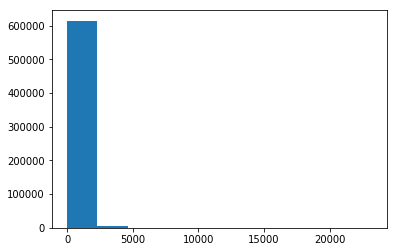

In [38]:
plt.hist(training.event_count)

(array([409270.,  83824.,  34815.,  18620.,  13261.,   9384.,   6589.,
          5082.,   4064.,  34514.]),
 array([  0. ,  71.7, 143.4, 215.1, 286.8, 358.5, 430.2, 501.9, 573.6,
        645.3, 717. ]),
 <a list of 10 Patch objects>)

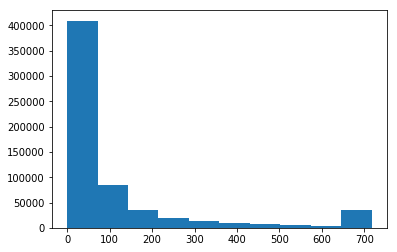

In [46]:
plt.hist(winsorize(training.event_count, limits=[0,0.05]))

/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(array([   334.,  35039.,  64329.,  51198., 104999., 105086.,  93102.,
         65097.,  42566.,  57673.]),
 array([0.        , 0.65750758, 1.31501517, 1.97252275, 2.63003034,
        3.28753792, 3.9450455 , 4.60255309, 5.26006067, 5.91756826,
        6.57507584]),
 <a list of 10 Patch objects>)

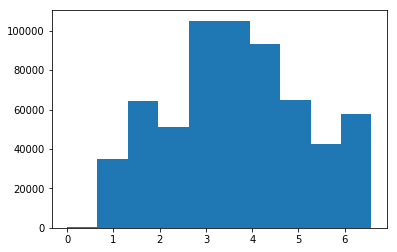

In [47]:
plt.hist(np.log(winsorize(training.event_count, limits=[0,0.05])))

In [45]:
training[training.event_count>10000]['user_purchase_binary_7_days']

5854      False
6871      False
25437      True
27646      True
44965     False
45866      True
93535     False
120760    False
124204     True
127955    False
172748     True
181179    False
191010    False
208431     True
229245    False
236202    False
241564    False
272527     True
284399     True
285393    False
288370    False
291583    False
315941     True
328567     True
357861     True
358147     True
378806    False
394427     True
419015    False
426870     True
439724    False
457369    False
467930     True
491403    False
502910     True
551192    False
560882    False
563844    False
579486    False
598121     True
600019     True
603035    False
615161    False
Name: user_purchase_binary_7_days, dtype: bool

### Categorical Feature Encoding
There are two categorical features, Country and OS, since OS only has 3 different values, we will use One-Hot Encoding. However, there are 200+ countries, we will use mean encoding for this feature, to avoid overfitting, we use 5-fold mean encoding to regularize the encoding.

In [200]:
# One-Hot Encoding OS
training['os_name'] = training['os_name'].fillna(value='Missing')
os = pd.get_dummies(training['os_name']).drop(columns = ['Missing'])
os['os_ios'], os['os_android'] = os['iOS']+os['iPhone OS'], os['Android OS']
os = os.loc[:,['os_ios', 'os_android']]
training = pd.concat((training,os), axis=1)

In [201]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,...,event_7,event_41,event_3,event_42,region,purchase_gap,country_mean_enc,region_mean_enc,os_ios,os_android
0,e1307a8f59cedf193a6b702914071b354618743ff55f52...,False,False,245,0,12,US,Android OS,7357318.5,0.0,...,4,6,6,5,tx,NaN,0.015190,0.013366,0,1
1,a3fd9faf3fe536411c656fa4286e1f2830f6ab88a7c2bb...,False,False,5,0,2,US,iOS,24242.5,0.0,...,0,0,0,0,tn,NaN,0.015402,0.010538,1,0
2,57fb27e539c679bb5ce5f8a0d975186008c42030061024...,False,False,21,0,1,US,Android OS,0.0,0.0,...,1,0,0,0,fl,NaN,0.015132,0.012966,0,1
3,6c75912a77f358dea7b4cc146931017e5f7aec1d948ed9...,False,False,56,0,1,US,Android OS,0.0,0.0,...,2,0,0,0,va,NaN,0.015116,0.017694,0,1
4,9f8bba6071e8d0f8ecb775c1a5ece35d5f6134e4870198...,False,False,14,0,1,US,Android OS,0.0,0.0,...,0,0,0,0,ca,NaN,0.015168,0.012560,0,1


In [ ]:
small_country = set(training.country.value_counts()[30:].keys())

training['country'] = training['country'].apply(lambda x: 'other' if x in small_country else x)

training['country'].value_counts()

In [112]:
train_y2 = training.user_purchase_binary_14_days
# Mean Encoding Country
def reg_target_encoding(train, col = "country", splits=5):

    train[f'{col}_mean_enc'] = 0
#     train_y2 = training.user_purchase_binary_14_days.values
    skf = StratifiedKFold(splits, shuffle=True, random_state=111)
    
    for computing_index, encoding_index in skf.split(training,train_y2):
        computing, encoding = train.iloc[computing_index], train.iloc[encoding_index]
        means = computing.groupby(col).user_purchase_binary_14_days.mean()
        train.loc[encoding_index,f'{col}_mean_enc'] = encoding[col].map(means)
reg_target_encoding(training)

In [121]:
small_region = set(training.region.value_counts()[50:].keys())

training['region'] = training['region'].apply(lambda x: 'other' if x in small_country else x)

training['region'].value_counts()

eng    38346
tx     28335
ca     25423
fl     17087
00     16127
ny     15111
ga     14733
?      14414
il     14367
tn     11593
pa     10915
mi     10801
oh     10538
nc     10464
mh      8221
on      7902
wa      7421
mo      6810
c       6480
la      6460
in      6015
va      5934
14      5928
nj      5888
gt      5845
ma      5693
co      5621
az      5472
nsw     5405
mn      5176
       ...  
lx         1
xa         1
053        1
099        1
087        1
tv         1
107        1
rd         1
065        1
oc         1
109        1
054        1
049        1
ek         1
huc        1
xo         1
016        1
un         1
050        1
pia        1
056        1
048        1
suc        1
015        1
fp         1
log        1
069        1
097        1
79         1
094        1
Name: region, Length: 742, dtype: int64

In [122]:
reg_target_encoding(training, col='region')

In [1]:
training.head()

NameError: name 'training' is not defined

## Prediction Features

Lets wrap up all feature generating procedures and use it in prediction dataset.

In [124]:
def mean_encoding_test(test, train, col = "country"):

    global_mean = train.user_purchase_binary_14_days.mean()
    mean_device_type = train.groupby(col).user_purchase_binary_14_days.mean()
    test[f'{col}_mean_enc'] = test[col].map(mean_device_type)
    test[f'{col}_mean_enc'].fillna(global_mean, inplace=True)

In [79]:
def feature_generate(df, events_df, session_df):
    
    # Feature one: event_count
    count = events_df.loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature two: purchase_count
    count = events_df[events_df.event=='8'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'purchase_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature three: session_count
    count = session_df.loc[:, ['user_id_hash', 'session_id']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'session_id':'session_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature four: country
    country = session_df.loc[:, ['user_id_hash', 'country']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(country.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature five: OS
    os = session_df.loc[:, ['user_id_hash', 'os_name']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(os.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature six: session_duration
    duration = session_df.loc[:, ['user_id_hash', 'previous_sessions_duration']].groupby('user_id_hash').\
    mean().reset_index().rename(columns={'previous_sessions_duration':'mean_sessions_duration'})
    df = df.join(duration.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature seven: spend
    spend = events_df[events_df.event=='8'].loc[:, ['user_id_hash', 'event_value']].groupby('user_id_hash').\
    sum().reset_index().rename(columns={'event_value':'spend'})
    df = df.join(spend.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature eight: event_gap
    event_gap = events_df.loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'event_timestamp':'event_gap'})
    event_gap['event_gap'] = 1544831999484 - event_gap['event_gap'] 
    df = df.join(event_gap.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature nine: session_gap
    session_gap = session_df.loc[:, ['user_id_hash', 'start_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'start_timestamp':'session_gap'})
    session_gap['session_gap'] = 1544831999484 - session_gap['session_gap'] 
    df = df.join(session_gap.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature ten: life_time
    life_time = session_df.loc[:, ['user_id_hash', 'user_created_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'user_created_timestamp':'life_time'})
    life_time['life_time'] = 1544831999484 - life_time['life_time'] 
    df = df.join(life_time.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 11: city
    city = session_df.loc[:, ['user_id_hash', 'city']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(city.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 12: num_places
    num_places = session_df.loc[:, ['user_id_hash', 'latitude']].groupby('user_id_hash').\
    nunique('latitude').drop(columns=['user_id_hash']).reset_index().rename(columns={'latitude':'num_places'})
    df = df.join(num_places.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 13: event_45
    event_45 = events_df[events_df.event=='45'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_45'})
    df = df.join(event_45.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 14: event_1
    event_1 = events_df[events_df.event=='1'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_1'})
    df = df.join(event_1.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 15: event_5
    event_5 = events_df[events_df.event=='5'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_5'})
    df = df.join(event_5.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 16: event_6
    event_6 = events_df[events_df.event=='6'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_6'})
    df = df.join(event_6.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 17: event_14
    event_14 = events_df[events_df.event=='14'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_14'})
    df = df.join(event_14.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 18: event_4
    event_4 = events_df[events_df.event=='4'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_4'})
    df = df.join(event_4.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 19: event_40
    event_40 = events_df[events_df.event=='40'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_40'})
    df = df.join(event_40.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 20: event_7
    event_7 = events_df[events_df.event=='7'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_7'})
    df = df.join(event_7.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 21: event_41
    event_41 = events_df[events_df.event=='41'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_41'})
    df = df.join(event_41.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 22: event_3
    event_3 = events_df[events_df.event=='3'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_3'})
    df = df.join(event_3.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 23: event_42
    event_42 = events_df[events_df.event=='42'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_42'})
    df = df.join(event_42.set_index('user_id_hash'), on = 'user_id_hash')    

    # Feature 24: region
    region = session_df.loc[:, ['user_id_hash', 'region']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(region.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature 25: purchase_gap
    purchase_gap = events_df[events_df.event=='8'].loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'event_timestamp':'purchase_gap'})
    purchase_gap['purchase_gap'] = 1544831999484 - purchase_gap['purchase_gap'] 
    df = df.join(purchase_gap.set_index('user_id_hash'), on = 'user_id_hash')

    return df

In [126]:
def feature_encoding(df, events_df, session_df):
# One-Hot Encoding OS
    df['os_name'] = df['os_name'].fillna(value='Missing')
    os = pd.get_dummies(df['os_name']).drop(columns = ['Missing'])
    os['os_ios'], os['os_android'] = os['iOS']+os['iPhone OS'], os['Android OS']
    os = os.loc[:,['os_ios', 'os_android']]
    df = pd.concat((df,os), axis=1)
# Mean Encoding country
    mean_encoding_test(df, training, col = "country")
    
# Mean Encoding region   
    mean_encoding_test(df, training, col = "region")
    return df

In [191]:
submit2 = submit2.rename(columns={'previous_sessions_duration': 'mean_sessions_duration'})

In [80]:
submit = feature_generate(submission, events, session)

In [127]:
submit2 = feature_encoding(submit, events, session)

In [179]:
submit.to_pickle('prediction.pkl')

In [41]:
submission.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.01,0.02
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.01,0.02
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.01,0.02
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.01,0.02
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.01,0.02


## Model

In [202]:
X = training.drop(columns =['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name','city','region'])
y = training['user_purchase_binary_7_days']
X_test = submit2.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name','city','region'])

In [204]:
X.shape

(619423, 25)

In [205]:
X_test.shape

(312568, 25)

In [206]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 40,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8,
         'bagging_seed': 11,
         'reg_alpha': 1.7,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.8,
#          'min_gain_to_split': 0.01,
#          'min_child_weight': 20,
         'num_threads': 8}

In [207]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                      valid_sets = [train_data, valid_data], 
                      verbose_eval=300, 
                      early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold

Fold 0 started at Tue Feb 19 00:27:27 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.975062	valid_1's auc: 0.9722
[600]	training's auc: 0.977128	valid_1's auc: 0.973809
[900]	training's auc: 0.978228	valid_1's auc: 0.974338
[1200]	training's auc: 0.978891	valid_1's auc: 0.974539
[1500]	training's auc: 0.97951	valid_1's auc: 0.974745
[1800]	training's auc: 0.980019	valid_1's auc: 0.974835
[2100]	training's auc: 0.980511	valid_1's auc: 0.974906
[2400]	training's auc: 0.981	valid_1's auc: 0.975005
[2700]	training's auc: 0.981468	valid_1's auc: 0.975052
[3000]	training's auc: 0.981894	valid_1's auc: 0.97512


In [ ]:
np.save('lgb_prediction_1', prediction1)


In [122]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                      valid_sets = [train_data, valid_data], 
                      verbose_eval=300, 
                      early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold

Fold 0 started at Mon Feb 18 04:12:04 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.974345	valid_1's auc: 0.971998
[600]	training's auc: 0.976271	valid_1's auc: 0.973568
[900]	training's auc: 0.977183	valid_1's auc: 0.97389
[1200]	training's auc: 0.978002	valid_1's auc: 0.974197
[1500]	training's auc: 0.978594	valid_1's auc: 0.974382
[1800]	training's auc: 0.979117	valid_1's auc: 0.974516
[2100]	training's auc: 0.979524	valid_1's auc: 0.974564
[2400]	training's auc: 0.979943	valid_1's auc: 0.974607
Early stopping, best iteration is:
[2344]	training's auc: 0.979854	valid_1's auc: 0.97465
Fold 1 started at Mon Feb 18 04:14:35 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.974003	valid_1's auc: 0.974068
[600]	training's auc: 0.975958	valid_1's auc: 0.975329
[900]	training's auc: 0.976866	valid_1's auc: 0.975858
[1200]	training's auc: 0.977602	valid_1's auc: 0.976209
[1500]	training's auc: 0.978206	v

In [ ]:
X = training.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])
y = training['user_purchase_binary_14_days']
X_test = submit.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])

In [ ]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                      valid_sets = [train_data, valid_data], 
                      verbose_eval=300, 
                      early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold

In [ ]:
prediction2 = prediction
np.save('lgb_prediction_2', prediction2)

In [148]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 40,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8,
         'bagging_seed': 11,
         'reg_alpha': 1.7,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.8,
#          'min_gain_to_split': 0.01,
#          'min_child_weight': 20,
         'num_threads': 8}
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [181]:
X = training.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])
y = training['user_purchase_binary_7_days']
X_test = submit.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])

In [182]:
import xgboost as xgb
import catboost as cab

In [183]:
cab.__version__

'0.12.2'

In [ ]:
model = cab.CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           task_type="CPU",
                           learning_rate=0.01,
                           iterations=10000,
                           random_seed=42,
                           od_type="Iter",
                           depth=10,
                           early_stopping_rounds=300
                          )

In [ ]:
from sklearn.metrics import roc_auc_score
target = y.apply(lambda x: int(x))
y_valid_pred = 0 * target
y_test_pred = 0
for idx, (train_index, valid_index) in enumerate(folds.split(X,y)):
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    _train = cab.Pool(X_train, label=y_train)
    _valid = cab.Pool(X_valid, label=y_valid)
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200,
                          plot=True
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "auc = ", roc_auc_score(y_valid, pred) )
    y_valid_pred.iloc[valid_index] = pred
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
y_test_pred /= n_split

In [ ]:
np.save('cab_prediction_1', y_test_pred)


In [ ]:
y = training['user_purchase_binary_14_days']
from sklearn.metrics import roc_auc_score
target = y.apply(lambda x: int(x))
y_valid_pred = 0 * target
y_test_pred = 0
for idx, (train_index, valid_index) in enumerate(folds.split(X,y)):
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    _train = cab.Pool(X_train, label=y_train)
    _valid = cab.Pool(X_valid, label=y_valid)
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200,
                          plot=True
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "auc = ", roc_auc_score(y_valid, pred) )
    y_valid_pred.iloc[valid_index] = pred
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
y_test_pred /= n_split

In [ ]:
np.save('cab_prediction_2', y_test_pred)

In [187]:
X_test.head()

,event_count,purchase_count,session_count,mean_sessions_duration,spend,event_gap,session_gap,life_time,num_places,event_45,...,event_5,event_6,event_14,event_4,event_40,event_7,event_41,event_3,event_42,purchase_gap
0,26.0,0.0,2.0,356544.00,0.0,4.169025e+09,4.169058e+09,4.219028e+09,1.0,17.0,...,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
1,50.0,0.0,1.0,0.00,0.0,1.962124e+09,2.068505e+09,2.068521e+09,1.0,31.0,...,3.0,3.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,NaN
2,31.0,0.0,4.0,388631.25,0.0,3.259103e+09,3.448174e+09,4.132000e+09,2.0,19.0,...,1.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN
3,207.0,0.0,10.0,9200582.90,0.0,2.712367e+09,2.714804e+09,4.368928e+09,2.0,142.0,...,9.0,8.0,6.0,7.0,5.0,4.0,5.0,4.0,2.0,NaN
4,5.0,0.0,1.0,0.00,0.0,5.332535e+09,5.507037e+09,5.507037e+09,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
np.save('lgb_prediction_1', prediction1)y_test_pred

In [ ]:
X = training.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])
y = training['user_purchase_binary_7_days']
X_test = submit.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name', 'city', 'region'])

In [127]:
submission['user_purchase_binary_7_days'] = prediction1
submission['user_purchase_binary_14_days'] = prediction2

In [128]:
submission.to_csv('submission0217.csv', index=False)

In [129]:
!kaggle competitions submit predict-in-app-purchase -f submission0217.csv -m "Using full 11 features and model on lgbm"

100%|██████████████████████████████████████| 32.6M/32.6M [00:02<00:00, 16.1MB/s]
Successfully submitted to Predict in-app purchases